In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import shutil

In [ ]:
shutil.rmtree('/content/OCT2017',ignore_errors=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/OCT2017_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: OCT2017/train/DRUSEN/DRUSEN-8986660-93.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-8023853-136.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-482704-24.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-781814-19.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-8345703-20.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-9800172-24.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-984816-3.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-8086850-58.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-2510299-1.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-8086850-219.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-2211381-1.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-538779-43.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-8440718-30.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-2112926-3.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-9563024-4.jpeg  
  inflating: OCT2017/train/DRUSEN/DRUSEN-5811898-10.jpeg  
  inflating:

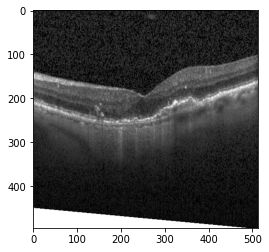

In [ ]:
#@title showing some image
import PIL
a=PIL.Image.open('/content/OCT2017/test/CNV/CNV-103044-3.jpeg')
b=np.asarray(a)
plt.imshow(b,cmap='gray')
plt.show()

In [ ]:
#@title check size
count=0
a=0
for path in os.listdir('/content/OCT2017/val/NORMAL'):
    # check if current path is a file
    if os.path.isfile(os.path.join('/content/OCT2017/val/NORMAL', path)):
        count += 1
    else:
      a+=1
print('File count:', count,a)

import os

count = 0
for root_dir, cur_dir, files in os.walk(r'/content/OCT2017/val'):
    count += len(files)
print('file count:', count)

File count: 8 0
file count: 32


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
target_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/OCT2017/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/val',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        color_mode='grayscale')

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


**Model**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy

Instead of having 2 conv layer we substitude them with a one conv layer with bigger kernel size that result in same output shape

In [ ]:
inp_layer = Input(shape = (224, 224,1))
conv1 = Conv2D(filters = 16, kernel_size=(14,14), strides = (2, 2), padding = 'valid')(inp_layer)
maxp2 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv1)
#residual block
conv3 = Conv2D(filters = 16,kernel_size=(4,4),strides=(1,1),padding='same',activation='relu')(maxp2)
norm1=BatchNormalization()(conv3)
conv4= Conv2D(filters = 16,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(norm1)
add_layer=layers.Add()([conv4, maxp2])
act_res =layers.Activation('relu')(add_layer)
##
conv5 = Conv2D(filters = 10, kernel_size=(3, 3), strides = (1, 1), padding = 'valid')(act_res)
maxp3 = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(conv5)

flat  = Flatten()(maxp3)
FC1   = Dense(units = 300, activation = 'relu')(flat)
FC2   = Dense(units = 200 , activation = 'relu')(FC1)
output = Dense(units = 4, activation = 'softmax')(FC2)

DaniNet = Model(inputs = inp_layer, outputs = output)
DaniNet.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 106, 106, 16  3152        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 53, 53, 16)  0           ['conv2d_36[0][0]']              
 )                                                                                          

In [ ]:
opt = Adam(learning_rate=0.001)
loss = categorical_crossentropy
DaniNet.compile(optimizer=opt, loss = loss, metrics = 'acc')

In [ ]:
results = DaniNet.fit(train_generator,epochs = 10,validation_data=validation_generator)

Epoch 1/10
5218/5218 [==============================] - 292s 56ms/step - loss: 0.5740 - acc: 0.7890 - val_loss: 0.2318 - val_acc: 0.9375
Epoch 2/10
5218/5218 [==============================] - 273s 52ms/step - loss: 0.3135 - acc: 0.8935 - val_loss: 0.0507 - val_acc: 1.0000
Epoch 3/10
5218/5218 [==============================] - 267s 51ms/step - loss: 0.2151 - acc: 0.9276 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 4/10
5218/5218 [==============================] - 267s 51ms/step - loss: 0.1534 - acc: 0.9491 - val_loss: 0.0544 - val_acc: 0.9688
Epoch 5/10
5218/5218 [==============================] - 267s 51ms/step - loss: 0.1169 - acc: 0.9618 - val_loss: 0.2021 - val_acc: 0.9375
Epoch 6/10
5218/5218 [==============================] - 266s 51ms/step - loss: 0.0956 - acc: 0.9686 - val_loss: 0.2908 - val_acc: 0.9375
Epoch 7/10
5218/5218 [==============================] - 266s 51ms/step - loss: 0.0839 - acc: 0.9732 - val_loss: 0.2304 - val_acc: 0.9375
Epoch 8/10
5218/5218 [===================

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = results.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/drive/MyDrive/DaniNet.json', 'w'))

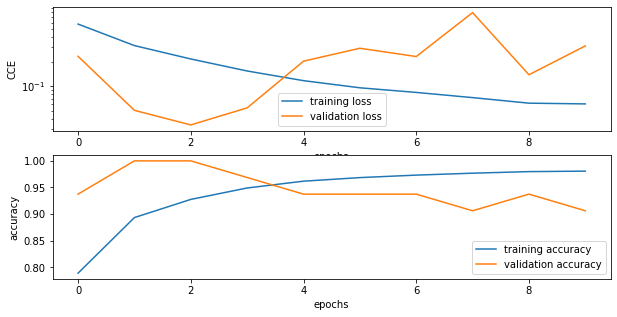

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = results.history['loss']
val_loss = results.history['val_loss']
train_acc = results.history['acc']
val_acc = results.history['val_acc']

plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.semilogy(train_loss)
plt.semilogy(val_loss)

plt.legend(['training loss', 'validation loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')

plt.subplot(2, 1, 2)
plt.plot(train_acc)
plt.plot(val_acc)

plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        '/content/OCT2017/test',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        color_mode='grayscale')

Found 968 images belonging to 4 classes.


In [ ]:
y_pred_valid = DaniNet.predict(test_generator)

In [ ]:
thresh = 0.6
y_pred_valid[y_pred_valid >= thresh] = 1
y_pred_valid[y_pred_valid < thresh]  = 0

In [ ]:
y_pred_valid=np.argmax(y_pred_valid,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_valid))

[[238   2   0   2]
 [ 13 219   1   9]
 [ 29   0 213   0]
 [  0   0   0 242]]


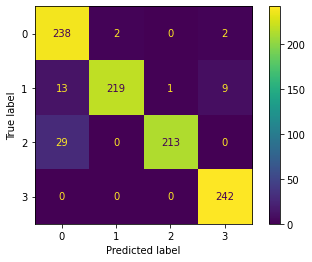

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_generator.classes, y_pred_valid)

**classification report**

In [ ]:
from sklearn.metrics import classification_report
cls_report = classification_report(test_generator.classes, y_pred_valid)

print(cls_report)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       242
           1       0.99      0.90      0.95       242
           2       1.00      0.88      0.93       242
           3       0.96      1.00      0.98       242

    accuracy                           0.94       968
   macro avg       0.95      0.94      0.94       968
weighted avg       0.95      0.94      0.94       968



results denotes that having a deeper CNN network with smaller kernel size give better output with lower parameter that give us more time and calculation efficiency